---
title: Zero Dealer Models
author: Andrei Akopian
date: 2026-01-24
format:
  html:
    code-fold: true
    code-summary: "Show the code"
  pdf:
    code-overflow: wrap
    echo: false
    output: true
---

Model that tries to predict zeros using RF to prevent Linear Regression from overfitting.

In [126]:
import numpy as np
import pandas as pd
import spectral_library
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = spectral_library.open_file('unmixing/original_data.csv')
fractions, nr900to1700, _ = spectral_library.take_subset(df,start=900,end=1700)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(nr900to1700, fractions, test_size=0.5, random_state=42)

In [12]:
def preformance_metric(truth, predicted):
    dot_product = np.dot(truth, predicted)
    magnitude_1 = np.linalg.norm(truth)
    magnitude_2 = np.linalg.norm(predicted)
    cosine_angle = dot_product / (magnitude_1 * magnitude_2)
    angle = np.arccos(cosine_angle)
    return angle

In [60]:
print(sum(npv_zeros))
print(sum(npv_zeros2))

199
233


Baseline linear regression

In [116]:
reg = linear_model.LinearRegression()
reg.fit(X=X_train,y=y_train)
predictions = reg.predict(X_test)
print("NPV r2", spectral_library.evaluate_model(y_test['npv_fraction'], [p[0] for p in predictions])[0])
print("GV r2", spectral_library.evaluate_model(y_test['gv_fraction'], [p[1] for p in predictions])[0])
print("Soil r2", spectral_library.evaluate_model(y_test['soil_fraction'], [p[2] for p in predictions])[0])

NPV r2 0.7477838848356202
GV r2 0.8606047077387966
Soil r2 0.8472451032858296


In [ ]:
# manual testing
baseline = linear_model.LinearRegression()
baseline.fit(X_train, y_train)

i = 2
fraction_name = ['npv_fraction', 'gv_fraction', 'soil_fraction'][i]

zeros = y_train[fraction_name].to_numpy() < 1e-4
zeros_indecies = [i for i, value in enumerate(zeros) if value]
zeros_spectra = X_train.iloc[zeros_indecies]
zeros_fractions = y_train.iloc[zeros_indecies]
reg = linear_model.LinearRegression()
reg.fit(X=zeros_spectra, y=zeros_fractions)

rf = RandomForestClassifier()
rf.fit(X_train, zeros)
print("RF", rf.score(X_test, y_test[fraction_name].to_numpy() < 1e-4))

zeros2 = rf.predict(X_test)
zeros_indecies2 = [i for i, value in enumerate(zeros2) if value]
zeros_spectra2 = X_test.iloc[zeros_indecies2]
zeros_fractions2 = y_test.iloc[zeros_indecies2]

predictions = reg.predict(X=zeros_spectra2)
for p in predictions:
    p[i] = 0
print(spectral_library.evaluate_model(predictions, zeros_fractions2))
predictions = baseline.predict(X=zeros_spectra2)
print(spectral_library.evaluate_model(predictions, zeros_fractions2))
predictions = baseline.predict(X=X_test)
print(spectral_library.evaluate_model(predictions, y_test))

RF 0.9338747099767981
[[0.42666195 0.57333811 0.        ]
 [0.53551857 0.46448162 0.        ]
 [0.47326963 0.52673037 0.        ]
 ...
 [0.88605487 0.11394505 0.        ]
 [0.55810853 0.44189136 0.        ]
 [0.4322534  0.56774646 0.        ]]
(array([0.69300217, 0.60734243,        nan]), (array([0.76306393, 0.72754095, 0.        ]), array([0.12153065, 0.15101903, 0.        ]), array([0.83246752, 0.77932177,        nan]), array([1.19942021e-105, 4.97621049e-084,             nan]), array([0.02526798, 0.02910429,        nan])))
(array([0.65068763, 0.73072413, 0.36778856]), (array([0.81330097, 0.78055174, 0.69961787]), array([ 0.10774959,  0.10130571, -0.00340353]), array([0.80665211, 0.85482404, 0.60645574]), array([2.63294620e-094, 3.68207218e-117, 3.87308114e-042]), array([0.02964704, 0.02357399, 0.04563544])))
(array([0.74778388, 0.86060471, 0.8472451 ]), (array([0.79125104, 0.88953214, 0.87773606]), array([0.09633598, 0.03982565, 0.02185879]), array([0.86474498, 0.92768783, 0.9204591

With fraction=0 isolation
npv r2 = 0.40014916966873343
Gv r2 = 0.9012640501148116
Soil r2 = 0.7961178116106843

In [27]:
reg.predict(X_test.iloc[0:1])

array([[-0.11206332,  1.18181787, -0.06974631]])

In [ ]:
# see how well RF Classifiers find zeros
rf = RandomForestClassifier(random_state=42)
npv_zeros_train = y_train['npv_fraction'].to_numpy() < 1e-4
rf.fit(X_train, npv_zeros_train)
npv_zeros_test = y_test['npv_fraction'].to_numpy() < 1e-4
print(rf.score(X_train, npv_zeros_train))
print(rf.score(X_test, npv_zeros_test))

1.0
0.9535962877030162


In [158]:
class ZeroDealerModel:
    def __init__(self):
        self.baseline = linear_model.LinearRegression()

        self.zero_npv_classifier = RandomForestClassifier(random_state=42)
        self.gv_soil_regressor = linear_model.LinearRegression()

        self.zero_gv_classifier = RandomForestClassifier(random_state=42)
        self.npv_soil_regressor = linear_model.LinearRegression()

        self.zero_soil_classifier = RandomForestClassifier(random_state=42)
        self.npv_gv_regressor = linear_model.LinearRegression()
        self.zero_threshold = 1e-3
    def fit(self, spectra, fractions):
        self.baseline.fit(spectra, fractions)
        print("Baseline Trained")

        npv_zeros = fractions['npv_fraction'].to_numpy() < self.zero_threshold
        gv_zeros = fractions['gv_fraction'].to_numpy() < self.zero_threshold
        soil_zeros = fractions['soil_fraction'].to_numpy() < self.zero_threshold

        self.zero_npv_classifier.fit(spectra, npv_zeros)
        self.zero_gv_classifier.fit(spectra, gv_zeros)
        self.zero_soil_classifier.fit(spectra, soil_zeros)
        print("Classifiers Trained")

        npv_zeros_indecies = [i for i, value in enumerate(npv_zeros) if value]
        npv_zeros_spectra = spectra.iloc[npv_zeros_indecies]
        npv_zeros_fractions = fractions.iloc[npv_zeros_indecies]
        self.gv_soil_regressor.fit(npv_zeros_spectra, npv_zeros_fractions)

        gv_zeros_indecies = [i for i, value in enumerate(gv_zeros) if value]
        gv_zeros_spectra = spectra.iloc[gv_zeros_indecies]
        gv_zeros_fractions = fractions.iloc[gv_zeros_indecies]
        self.npv_soil_regressor.fit(gv_zeros_spectra, gv_zeros_fractions)

        soil_zeros_indecies = [i for i, value in enumerate(soil_zeros) if value]
        soil_zeros_spectra = spectra.iloc[soil_zeros_indecies]
        soil_zeros_fractions = fractions.iloc[soil_zeros_indecies]
        self.npv_gv_regressor.fit(soil_zeros_spectra, soil_zeros_fractions)
        print("Regressors Trained")

    def predict(self, spectra):
        npv_zeros = self.zero_npv_classifier.predict(spectra)
        gv_zeros = self.zero_gv_classifier.predict(spectra)
        soil_zeros = self.zero_soil_classifier.predict(spectra)

        predictions = []
        for i in range(spectra.shape[0]):
            prediction = [1/3,1/3,1/3]
            if all([npv_zeros[i], gv_zeros[i], soil_zeros[i]]):
                prediction = self.baseline.predict(spectra.iloc[i:i+1])
            elif gv_zeros[i] and soil_zeros[i]:
                prediction = [1, 0, 0]
            elif npv_zeros[i] and soil_zeros[i]:
                prediction = [0, 1, 0]
            elif npv_zeros[i] and gv_zeros[i]:
                prediction = [0, 0, 1]
            elif npv_zeros[i]:
                temp = self.gv_soil_regressor.predict(spectra.iloc[i:i+1])[0]
                prediction = np.array(temp)
            elif gv_zeros[i]:
                temp = self.npv_soil_regressor.predict(spectra.iloc[i:i+1])[0]
                prediction = np.array(temp)
            elif soil_zeros[i]:
                temp = self.npv_gv_regressor.predict(spectra.iloc[i:i+1])[0]
                prediction = np.array(temp)
            else:
                temp = self.baseline.predict(spectra.iloc[i:i+1])[0]
                prediction = np.array(temp)
            prediction = np.clip(prediction, a_min=0, a_max=1) / np.linalg.norm(prediction)
            predictions.append(prediction)
        return predictions, (npv_zeros, gv_zeros, soil_zeros)

    def score(self, spectra, fractions):
        predictions, rf_detections = zdm.predict(spectra)
        npv = [p[0] for p in predictions]
        gv = [p[1] for p in predictions]
        soil = [p[2] for p in predictions]

        print(confusion_matrix(fractions['npv_fraction'].to_numpy() < self.zero_threshold, rf_detections[0]))
        print(confusion_matrix(fractions['gv_fraction'].to_numpy() < self.zero_threshold, rf_detections[1]))
        print(confusion_matrix(fractions['soil_fraction'].to_numpy() < self.zero_threshold, rf_detections[2]))

        print("==== Overall ====")
        npv_r2 = spectral_library.evaluate_model(fractions['npv_fraction'], npv)[0]
        gv_r2 = spectral_library.evaluate_model(fractions['gv_fraction'], gv)[0]
        soil_r2 = spectral_library.evaluate_model(fractions['soil_fraction'], soil)[0]
        print("npv r^2 =", npv_r2)
        print("gv r^2 =", gv_r2)
        print("soil r^2 =", soil_r2)
        print("average r^2 =", sum([npv_r2, gv_r2, soil_r2])/3)
        return npv, gv, soil

In [159]:
zdm = ZeroDealerModel()
zdm.fit(X_train, y_train)
npv, gv, soil = zdm.score(X_test, y_test)


Baseline Trained
Classifiers Trained
Regressors Trained
[[802   7]
 [ 33  20]]
[[600  29]
 [ 62 171]]
[[425  26]
 [ 35 376]]
==== Overall ====
npv r^2 = 0.7595085935556203
gv r^2 = 0.8014607763643722
soil r^2 = 0.8086142294409836
average r^2 = 0.789861199786992


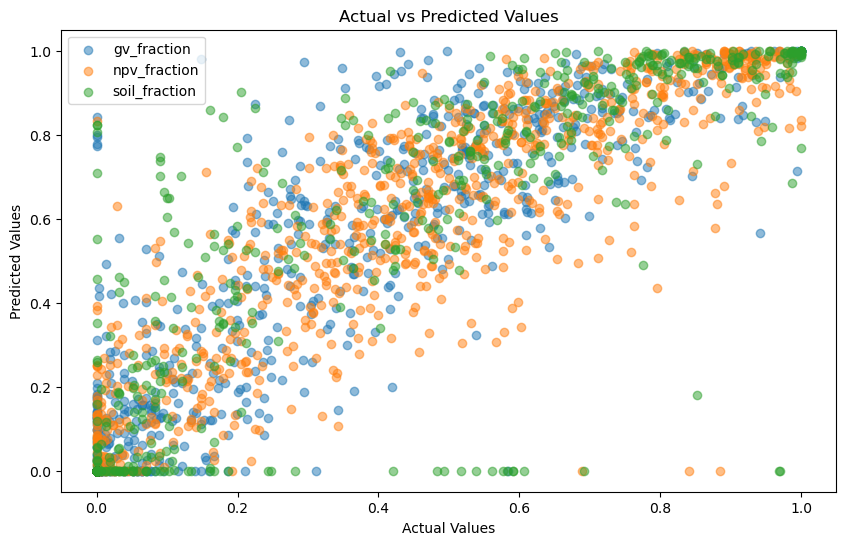

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test['gv_fraction'], gv, alpha=0.5, label="gv_fraction")
plt.scatter(y_test['npv_fraction'], npv, alpha=0.5, label="npv_fraction")
plt.scatter(y_test['soil_fraction'], soil, alpha=0.5, label="soil_fraction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("Actual vs Predicted Values")
plt.show()